In [1]:
from IBA.tensorflow_v1 import IBALayer, to_saliency_map
from gernerate_data import load_clas_seg_data
from sklearn.preprocessing import LabelBinarizer
from keras.models import load_model, Model
from models.MTL_IBA import MTL_IBA_cross3
from keras.utils.np_utils import *
import matplotlib.pyplot as plt
import matplotlib as mpl
import keras.backend as K
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import pickle
import cv2
import os


/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



Using TensorFlow backend.


In [2]:
                      
def plot_saliency_map(saliency_map, img, img_out_path):
    
    # 除去均值
    mean = np.mean(saliency_map, axis=0)
    maxi = np.max(saliency_map)
    mini = np.min(saliency_map)
    saliency_map = (saliency_map - mean)/(maxi-mini)
    
#     mean = np.mean(saliency_map,axis = -1)
#     # 取出大于0的显著点
    
#     maxi = np.maximum(saliency_map, 0)
    saliency_map /= float(np.log(2))
    saliency_map = saliency_map / np.max(saliency_map)
#     

    dpi = 100
    fig = plt.figure(frameon=False)
    fig.set_size_inches(img.shape[1] / dpi, img.shape[0] / dpi)
#     plt.imshow(img)
    
    saliency_map = cv2.resize(saliency_map, (img.shape[1], img.shape[0]))
#     heatmap = np.uint8(255 * saliency_map)
    
    #  定义颜色 color map
    vmax = saliency_map.max()
    norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
    n = 255
    half_jet_rgba = plt.cm.seismic(np.linspace(0.5, 1, n))
    half_jet_rgba[:, -1] = np.linspace(0.2, 1, n)
    cmap = mpl.colors.ListedColormap(half_jet_rgba)
    hmap_jet = cmap(norm(saliency_map))
    

    min_alpha=0.2
    max_alpha=0.7
    if img is not None:
        hmap_jet[:, :, -1] = (max_alpha - min_alpha)*norm(saliency_map)+ min_alpha
#         hmap_jet[:, :, -1] = (max_alpha - min_alpha)*norm(saliency_map) + min_alpha
    
    hmap_jet = np.clip(hmap_jet, 0, 255)
    plt.axis('off')
    plt.imshow(hmap_jet, alpha=1, cmap=cmap) # alpha设置透明度, cmap可以选择颜色
#     plt.savefig(img_out_path)
    fig.savefig(img_out_path, dpi=dpi, bbox_inches='tight', pad_inches=-0.1)
    print(img_out_path)
    
    
def to_unit_interval(x):
    """Scales ``x`` to be in ``[0, 1]``."""
#     return (x - x.min()) / (x.max() - x.min())
    return x / 255

In [3]:
Name =  'MTL_IBA_bit'
img_size = 224
depth = 3
target = (img_size, img_size)

trainX_dir = 'dataset/Dataset_BUSI_AN/train/images/'
valX_dir = 'dataset/Dataset_BUSI_AN/val/images/'
testX_dir = 'dataset/Dataset_BUSI_AN/test/images/'
save_dir = 'dataset/prediction/Dataset_BUSI_AN/' + Name
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
       

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
   
base_model = MTL_IBA_cross3(img_size, img_size, depth, nClasses=2)
base_model.load_weights('MTL-IBA.h5', by_name=True)
model = Model(inputs=base_model.input, outputs=base_model.get_layer('classification_output').output)
model.summary()





Instructions for updating:
Colocations handled automatically by placer.
lamb################################# Tensor("iba/Sigmoid:0", shape=(1, 28, 28, 256), dtype=float32)
Z_with_passing################################# Tensor("iba/mul_6:0", shape=(?, 28, 28, 256), dtype=float32)
output################################# Tensor("iba/cond_2/Merge:0", shape=(?, 28, 28, 256), dtype=float32)


2022-04-21 11:50:28.025250: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-04-21 11:50:28.061263: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2200095000 Hz
2022-04-21 11:50:28.065987: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x5ec2b30 executing computations on platform Host. Devices:
2022-04-21 11:50:28.066142: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
2022-04-21 11:50:28.581289: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x5f6eb90 executing computations on platform CUDA. Devices:
2022-04-21 11:50:28.581395: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2022-04-21 11:50:28.582756: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1433] Found device 0 with properties: 
name: Tes

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________

In [4]:

import keras
opt = keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.99, epsilon=1e-08, decay=0.01)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# 加载数据
train_x, train_c_y, train_s_y = load_clas_seg_data(trainX_dir, target)
val_x, val_c_y, val_s_y = load_clas_seg_data(valX_dir, target)
test_x, test_c_y, test_s_y = load_clas_seg_data(testX_dir, target,  shuffle=False)

lb = LabelBinarizer()
train_c_y = lb.fit_transform(train_c_y)
train_c_y = to_categorical(train_c_y, 2)
val_c_y = lb.fit_transform(val_c_y)
val_c_y = to_categorical(val_c_y, 2)
test_c_y = lb.fit_transform(test_c_y)
test_c_y = to_categorical(test_c_y, 2)


In [5]:
# 评估模型
# scores = model.evaluate(test_x, test_c_y, verbose=1)

loss, acc = model.evaluate(test_x, test_c_y, verbose=1)
print('Test classification loss:', loss)
print('Test classification accuracy:', acc)


2022-04-21 11:50:51.217075: I tensorflow/stream_executor/dso_loader.cc:152] successfully opened CUDA library libcublas.so.10.0 locally


64/64 [==============================] - 4s 66ms/step
Test classification loss: 0.6326294355094433
Test classification accuracy: 0.921875


In [6]:
run_training = False
from keras.preprocessing.image import ImageDataGenerator


if run_training: 
    datagen = ImageDataGenerator(
        rotation_range=20,  
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,  # randomly flip images
    )

    datagen.fit(train_x)

    # Fit the model on the batches generated by datagen.flow().
    hist = model.fit_generator(
        datagen.flow(train_x, train_c_y, batch_size=8), 
        epochs=100, 
        steps_per_epoch=len(train_x) // 8,
        validation_data=(val_x, val_c_y), workers=4)
    
    model.save_weights("IBA_post_visual")
    
    
# Score trained model.
scores = model.evaluate(test_x, test_c_y, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

64/64 [==============================] - 1s 9ms/step
Test loss: 0.6324627809226513
Test accuracy: 0.921875


In [7]:
from IBA.tensorflow_v1 import IBALayer, model_wo_softmax, to_saliency_map 


model_logits = Model(inputs=model.inputs, outputs=model.get_layer('cls_dense_out').output, name=model.name)

iba = model.layers[14]
target = iba.set_classification_loss(model_logits.output)

# ensure model is in eval mode
K.set_learning_phase(0)

for img in tqdm(train_x[:]):
    iba.fit({model.input: img[None]})


# # after layer block4_conv1 the bottleneck will be added
# feat_layer = model.get_layer(name='block5_c_conv1')


# iba = IBACopyInnvestigate(
#     model,
#     neuron_selection_mode='index',
#     feature_name=feat_layer.output.name,
# )

# # estimate feature mean and std
# val_gen = get_imagenet_generator(imagenet_dir)
# iba.fit([, ], steps_per_epoch=50)

# # load image
# monkeys, target = load_monkeys()
# monkeys_scaled =  preprocess_input(monkeys)

# # get the saliency map and plot
# saliency_map = iba.analyze(monkeys_scaled[None], neuron_selection=target)
# plot_saliency_map(saliency_map, img=monkeys)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 106.54it/s]


dataset/prediction/Dataset_BUSI_AN/IBA/benign (51).png
dataset/prediction/Dataset_BUSI_AN/IBA/benign (299).png
dataset/prediction/Dataset_BUSI_AN/IBA/benign (167).png
dataset/prediction/Dataset_BUSI_AN/IBA/benign (220).png
dataset/prediction/Dataset_BUSI_AN/IBA/benign (297).png
dataset/prediction/Dataset_BUSI_AN/IBA/benign (425).png
dataset/prediction/Dataset_BUSI_AN/IBA/benign (57).png
dataset/prediction/Dataset_BUSI_AN/IBA/benign (38).png
dataset/prediction/Dataset_BUSI_AN/IBA/benign (222).png
dataset/prediction/Dataset_BUSI_AN/IBA/benign (372).png
dataset/prediction/Dataset_BUSI_AN/IBA/benign (140).png
dataset/prediction/Dataset_BUSI_AN/IBA/benign (155).png
dataset/prediction/Dataset_BUSI_AN/IBA/benign (321).png
dataset/prediction/Dataset_BUSI_AN/IBA/benign (15).png
dataset/prediction/Dataset_BUSI_AN/IBA/benign (103).png
dataset/prediction/Dataset_BUSI_AN/IBA/benign (154).png
dataset/prediction/Dataset_BUSI_AN/IBA/benign (221).png
dataset/prediction/Dataset_BUSI_AN/IBA/benign (136).

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


dataset/prediction/Dataset_BUSI_AN/IBA/benign (231).png
dataset/prediction/Dataset_BUSI_AN/IBA/benign (127).png
dataset/prediction/Dataset_BUSI_AN/IBA/benign (21).png
dataset/prediction/Dataset_BUSI_AN/IBA/benign (150).png
dataset/prediction/Dataset_BUSI_AN/IBA/benign (315).png
dataset/prediction/Dataset_BUSI_AN/IBA/benign (104).png
dataset/prediction/Dataset_BUSI_AN/IBA/benign (142).png
dataset/prediction/Dataset_BUSI_AN/IBA/benign (119).png
dataset/prediction/Dataset_BUSI_AN/IBA/benign (153).png
dataset/prediction/Dataset_BUSI_AN/IBA/benign (88).png
dataset/prediction/Dataset_BUSI_AN/IBA/benign (388).png
dataset/prediction/Dataset_BUSI_AN/IBA/benign (48).png
dataset/prediction/Dataset_BUSI_AN/IBA/benign (316).png
dataset/prediction/Dataset_BUSI_AN/IBA/benign (81).png
dataset/prediction/Dataset_BUSI_AN/IBA/benign (349).png
dataset/prediction/Dataset_BUSI_AN/IBA/benign (84).png
dataset/prediction/Dataset_BUSI_AN/IBA/benign (364).png
dataset/prediction/Dataset_BUSI_AN/IBA/benign (353).p

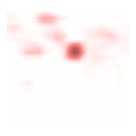

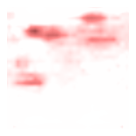

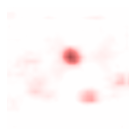

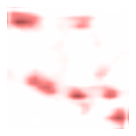

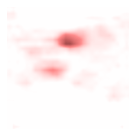

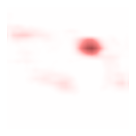

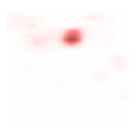

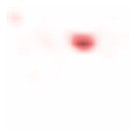

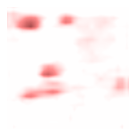

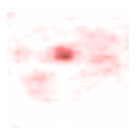

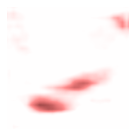

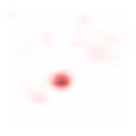

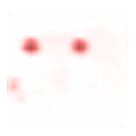

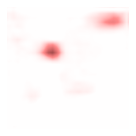

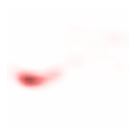

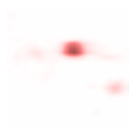

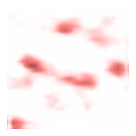

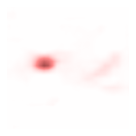

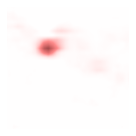

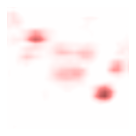

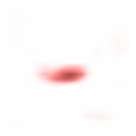

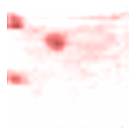

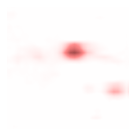

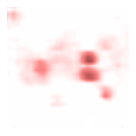

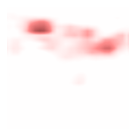

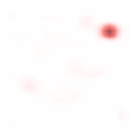

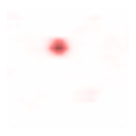

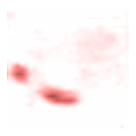

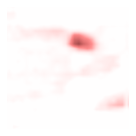

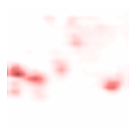

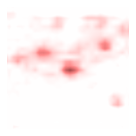

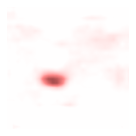

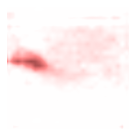

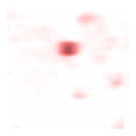

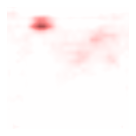

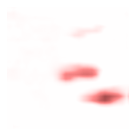

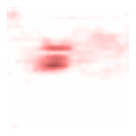

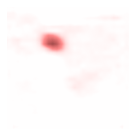

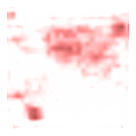

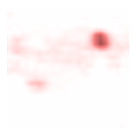

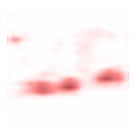

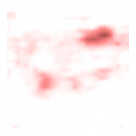

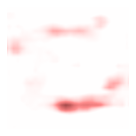

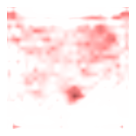

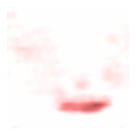

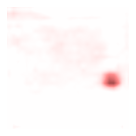

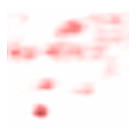

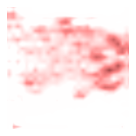

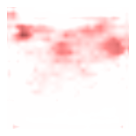

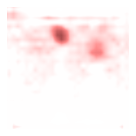

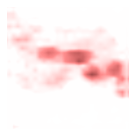

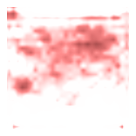

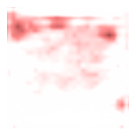

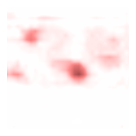

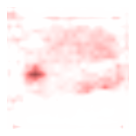

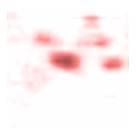

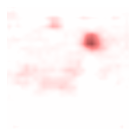

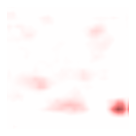

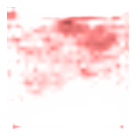

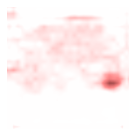

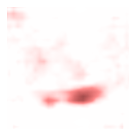

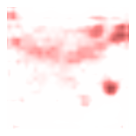

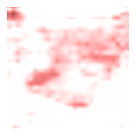

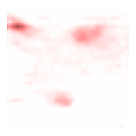

In [8]:
# estimate mean, std on 5000 samples
# for img in test_x[:500]:
#     iba.fit({model.input: img[None]})

save_dir = 'dataset/prediction/Dataset_BUSI_AN/IBA'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

# 列表记录测试图片的名字
test_images_names = []
class_list = os.listdir(testX_dir)
for class_name in class_list:
    class_path = os.path.join(testX_dir, class_name)
    img_list = os.listdir(class_path)
    for image_Name in img_list:
        test_images_names.append(image_Name)

for i, img in enumerate(test_x):
        
#         img = to_unit_interval(img)
        img =  np.expand_dims(img, axis=0)
        prediction = test_c_y[i].nonzero()[0]
        capacity = iba.analyze({model.input: img, iba.target: prediction})
        saliency_map = to_saliency_map(capacity, shape=(224, 224))
        img = np.squeeze(img)
        save_img_Path = os.path.join(save_dir, test_images_names[i])
        plot_saliency_map(saliency_map, img=img, img_out_path=save_img_Path)

##  Access to internal values

You can access all intermediate values of the optimzation through the iba.get_report() method. To store the intermediate values, you have to call either iba.collect_all() or iba.collect(*var_names) before running iba.analyze(..).

In [9]:
from IBA.tensorflow_v1 import IBALayer, model_wo_softmax, to_saliency_map 

# collect all intermediate tensors
iba.collect_all()

# storing all tensors can slow down the optimization. 
# you can also select to store only specific ones:
# iba.collect("alpha", "model_loss")
# to only collect a subset all all tensors

# run analyze

i = 4
img = test_x[i][None]
target = test_c_y[i].nonzero()[0]
capacity = iba.analyze({model.input: img, iba.target: target})
saliency_map = to_saliency_map(capacity, shape=(224, 224))

# get all saved variables
report = iba.get_report()

In [10]:
print("iterations:", list(report.keys()))

iterations: ['init', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 'final']


In [11]:
print("{:<30} {:}".format("name:", "shape"))
print()
for name, val in report['init'].items():
    print("{:<30} {:}".format(name + ":", str(val.shape)))

name:                          shape

alpha:                         (1, 28, 28, 256)
capacity:                      (10, 28, 28, 256)
capacity_mean:                 ()
capacity_no_nans:              (10, 28, 28, 256)
cross_entropy:                 (10,)
grad_loss_wrt_alpha:           (1, 28, 28, 256)
information_loss:              ()
lambda:                        (1, 28, 28, 256)
lambda_pre_blur:               (1, 28, 28, 256)
logits:                        (10, 2)
loss:                          ()
model_loss:                    ()
perturbed_feature:             (10, 28, 28, 256)
perturbed_feature_passing:     (10, 28, 28, 256)
feature:                       (1, 28, 28, 256)
feature_mean:                  (1, 28, 28, 256)
feature_std:                   (1, 28, 28, 256)
pass_mask:                     (10, 28, 28, 256)


## Losses during optimization

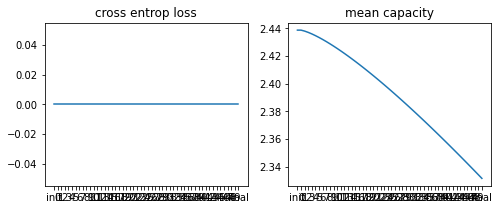

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].set_title("cross entrop loss")
ax[0].plot(list(report.keys()), [it['model_loss'] for it in report.values()])

ax[1].set_title("mean capacity")
ax[1].plot(list(report.keys()), [it['capacity_mean'] for it in report.values()])

##  Distribution of alpha (pre-softmax) values per iteraton

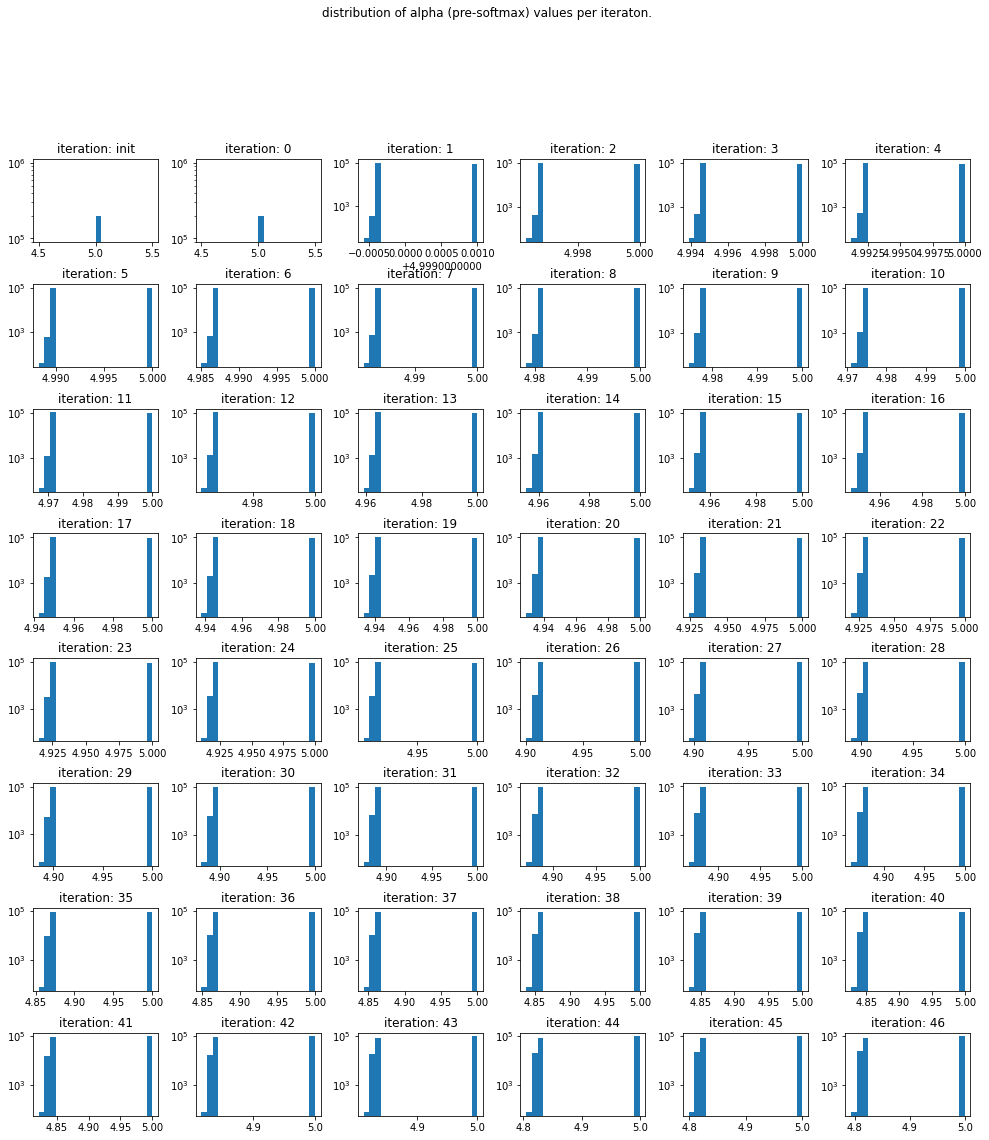

In [13]:
cols = 6
rows = len(report) // cols

fig, axes = plt.subplots(rows, cols, figsize=(2.8*cols, 2.2*rows))

for ax, (it, values) in zip(axes.flatten(), report.items()):
    ax.hist(values['alpha'].flatten(), log=True, bins=20)
    ax.set_title("iteration: " + str(it))
    
plt.subplots_adjust(wspace=0.3, hspace=0.5)

fig.suptitle("distribution of alpha (pre-softmax) values per iteraton.", y=1)
plt.show()

## Distributiuon of the final capacity

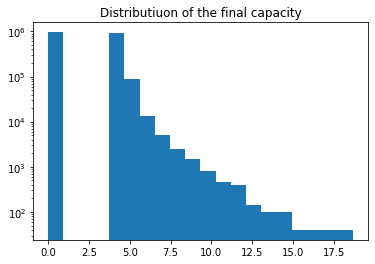

In [14]:
plt.hist(report['final']['capacity'].flatten(), bins=20, log=True)
plt.title("Distributiuon of the final capacity")
plt.show()

## 使用Investigate

In [15]:
import innvestigate
import innvestigate.utils
import keras.applications.vgg16 as vgg16
from keras.layers import *

# Get model
# model, preprocess = vgg16.VGG16(), vgg16.preprocess_input
# Strip softmax layer
# model = innvestigate.utils.model_wo_softmax(model)



# Create analyzer
analyzer = innvestigate.create_analyzer("smoothgrad", model_investigate)

'''
# Trainable methods
analyzer = innvestigate.create_analyzer("pattern.net", model_investigate)
for img in tqdm(train_x[:]):
    analyzer.fit(X_train)
'''

# 列表记录测试图片的名字
test_images_names = []
class_list = os.listdir(testX_dir)
for class_name in class_list:
    class_path = os.path.join(testX_dir, class_name)
    img_list = os.listdir(class_path)
    for image_Name in img_list:
        test_images_names.append(image_Name)


for i, img in enumerate(test_x):
        
#         img = to_unit_interval(img)
        img =  np.expand_dims(img, axis=0)
        prediction = test_c_y[i].nonzero()[0]
        
        a = analyzer.analyze(img)
        # Aggregate along color channels and normalize to [-1, 1]
        a = a.sum(axis=np.argmax(np.asarray(a.shape) == 3))
        a /= np.max(np.abs(a))
        # Plot
        plt.imshow(a[0], cmap="seismic", clim=(-1, 1))
#         plot_saliency_map(a, img=img, img_out_path=save_img_Path)


NameError: name 'model_investigate' is not defined

In [ ]:
# estimate mean, std on 5000 samples
# for img in test_x[:500]:
#     iba.fit({model.input: img[None]})





In [ ]:
# import innvestigate



# analysis = analyzer.analyze(X_test)